In [30]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 전처리


In [31]:
df=pd.read_csv("dataset.csv")
del df["id"]
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


### 데이터는 stroke 여부를 예측하는것

In [32]:
df.isnull().sum()/ len(df)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.033687
smoking_status       0.306267
stroke               0.000000
dtype: float64

In [33]:
del df["smoking_status"]  #결측치 30% 이상이므로 삭제

In [34]:
bins = [0, 10, 20, 30,40,50, 60,70,80,90]
labels = ['kids','10s', '20s', '30s', '40s', '50s','60s','70s','80s']
df["age_range"]=pd.cut(df["age"], bins,labels=labels)
df["age_range"]

0        kids
1         50s
2        kids
3         60s
4         10s
         ... 
43395    kids
43396     50s
43397     80s
43398     30s
43399     80s
Name: age_range, Length: 43400, dtype: category
Categories (9, object): ['kids' < '10s' < '20s' < '30s' ... '50s' < '60s' < '70s' < '80s']

In [35]:
#나이대 별로 bmi의 평균을 구함

bmi_mean= df["bmi"].groupby(df["age_range"]).mean()
bmi_mean

age_range
kids    18.866401
10s     24.993708
20s     28.712198
30s     30.677261
40s     31.186276
50s     31.464315
60s     31.149074
70s     29.079810
80s     27.566589
Name: bmi, dtype: float64

In [36]:
# BMI가 빈곳에 나이대 별 평균 BMI로 채움

for i in range (0,9):
    df.loc[(df["age_range"]== labels[i]) & (df["bmi"].isnull()), 'bmi'] = bmi_mean[i] 
    
df['bmi'].isnull().sum()

0

In [37]:
df=df.drop("age_range",axis=1)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,0
...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,0


In [38]:
y=df[["stroke"]]
x=df.drop("stroke", axis=1)

In [39]:
y=y.values

### 파이프라인

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attributes =["age","avg_glucose_level","bmi"]
x_num = x[num_attributes]

num_pipeline = Pipeline([
 
 ('std_scaler', StandardScaler()),
 ])
scaled_x_num = num_pipeline.fit_transform(x_num)

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_attribs =["age","avg_glucose_level","bmi"]
cat_attribs = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
x_prepared = full_pipeline.fit_transform(x)

In [42]:
x_prepared.shape

(43400, 19)

In [43]:
y.shape

(43400, 1)

<AxesSubplot:xlabel='stroke', ylabel='count'>

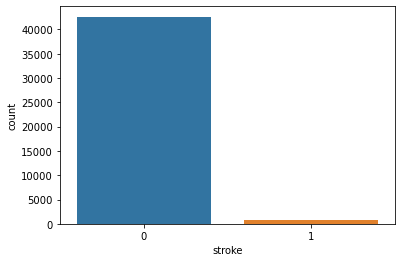

In [44]:
import seaborn as sns

sns.countplot(data=
              df,x='stroke')

In [63]:
# train, validation, test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_prepared, y, test_size=0.4, stratify = y ,random_state=42)

X_test, X_val, y_test, y_val =  train_test_split(X_test, y_test, test_size=0.5, stratify= y_test, random_state=42)

### y값이 불균형이 심해서 train set에서 오버샘플링 하려함

In [77]:

from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_train_over,y_train_over = sm.fit_resample(X_train,y_train)


In [78]:
X_train.shape , X_train_over.shape

((26040, 19), (51140, 19))

#### train sample의 수가 26040개에서 51140개로 늘어난 것을 볼 수 있다.

In [79]:
y_train_over = y_train_over.reshape(-1,1)
y_train_over

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [89]:
X_train = torch.FloatTensor(X_train_over)
y_train = torch.FloatTensor(y_train_over)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)


In [81]:
y_train

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

### 모델링

In [82]:
 import matplotlib.pyplot as plt

In [99]:
# optimizer, learning rate, epoch 을 입력 받는 함수



def mlp(opt,lr,epoch):
    
    
    model = nn.Sequential(
          nn.Linear(19, 100, bias=True),  # input_layer = 19, hidden_layer1 = 100 
          nn.LeakyReLU(),                 # 은닉층 활성화 함수로 leaky relu 사용
          nn.Linear(100, 100, bias=True), # hidden_layer1 = 100, hidden_layer2 = 100
          nn.LeakyReLU(),
          nn.Linear(100, 1, bias=True),   # hidden_layer3 = 100, output_layer = 1
          nn.Sigmoid()                    # 이진 분류이므로 출력층의 활성화 함수는 시그모이드
          ).to(device)
        
        
        
    loss_fn = nn.BCELoss().to(device)
    optimizer = opt(model.parameters(), lr=lr)
    losses = []
    
    val_loss=[]
    for epoch in range(epoch):

        optimizer.zero_grad()
        # forward 연산
        hypothesis = model(X_train)

        # 비용 함수
        cost = loss_fn(hypothesis, y_train)
        cost.backward()
        optimizer.step()
        losses.append(cost.item()) # 값만 가져오기 위해서 .item()

       
        val_pred= model(X_val)
        val_cost=loss_fn(val_pred, y_val)
        val_loss.append(val_cost.item())
        
        # 50의 배수에 해당되는 에포크마다 비용을 출력
        if epoch % 50 == 0:
            print(epoch, cost.item())
            
    plt.plot(losses, label = 'train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.show()
    
   
    

### SGD를 사용했을 때

0 0.6990976333618164
50 0.44280803203582764


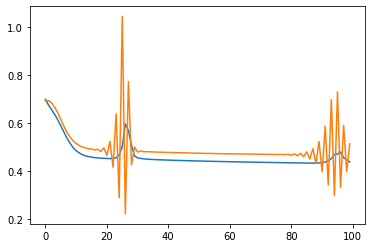

In [100]:
mlp(optim.SGD,0.7,100)

0 0.6875328421592712
50 0.44871851801872253


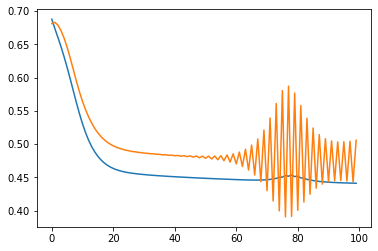

In [101]:
mlp(optim.SGD,0.5,100)

0 0.6952810883522034
50 0.5455443263053894
100 0.46349671483039856
150 0.4528028964996338
200 0.4483637809753418
250 0.44510555267333984
300 0.44260406494140625
350 0.44051018357276917
400 0.43867751955986023
450 0.4370080232620239


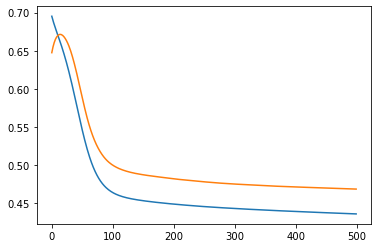

In [104]:
mlp(optim.SGD,0.1,500)

#### lr 이 컸을때 overfitting 이 일어난것을 볼 수 있다.

0 0.6950837969779968
50 50.0
100 50.0
150 50.0
200 50.0
250 50.0
300 50.0
350 50.0
400 50.0
450 50.0


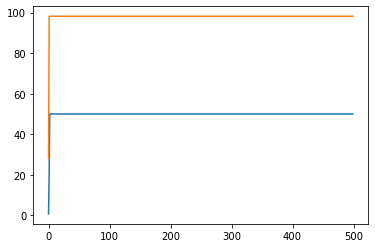

In [105]:
mlp(optim.Adam,0.5,500)

# 결과가 비정상적인데 원인을 잘 모르겠음

0 0.7047443389892578
50 0.42704683542251587


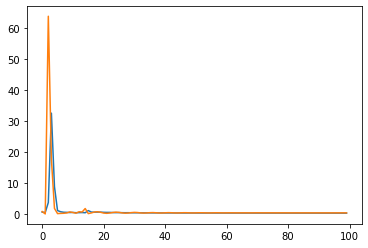

In [108]:
mlp(optim.Adam,0.1,100)

0 0.6912195682525635
50 0.3871002197265625


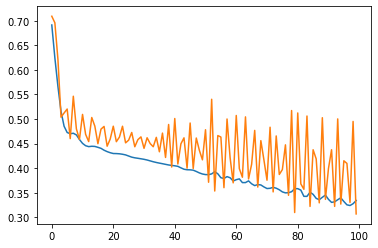

In [107]:
mlp(optim.Adam,0.01,100)

0 0.6896964907646179
50 21.221973419189453


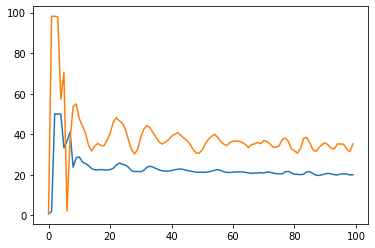

In [109]:
mlp(optim.Adam,0.2,100)

0 0.6938520669937134
50 0.44958433508872986
100 0.4264977276325226
150 0.40631088614463806
200 0.37688323855400085
250 0.34535038471221924
300 0.3200770616531372
350 0.2997824251651764
400 0.28507038950920105
450 0.2715873420238495


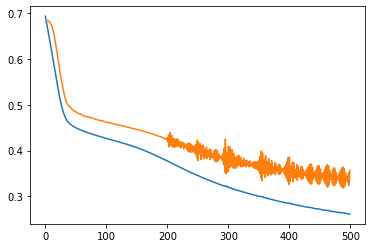

In [112]:
mlp(optim.Adam,0.001,500)

### Adam optimizer의 경우 lr 이 작을 때 validation loss 도 감소하는 추세를 보인다.

In [118]:
 model = nn.Sequential(
          nn.Linear(19, 100, bias=True),  # input_layer = 19, hidden_layer1 = 100 
          nn.LeakyReLU(),                 # 은닉층 활성화 함수로 leaky relu 사용
          nn.Linear(100, 100, bias=True), # hidden_layer1 = 100, hidden_layer2 = 100
          nn.LeakyReLU(),
          nn.Linear(100, 1, bias=True),   # hidden_layer3 = 100, output_layer = 1
          nn.Sigmoid()                    # 이진 분류이므로 출력층의 활성화 함수는 시그모이드
          ).to(device)
        
        
        
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [130]:
for epoch in range(500):

        # forward 연산
        hypothesis = model(X_train)

        # 비용 함수
        cost = loss_fn(hypothesis, y_train)
        
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

In [131]:
with torch.no_grad():

    model = model.to('cpu')
    y_pred = model(X_test)

   
    
    predicted = y_pred >= torch.FloatTensor([0.5])
    print(f'model의 output은 :  {y_pred[0]}' )
    print(f'sigmoid를 한 후의 output은 {predicted[0]}')
    accuracy = (accuracy_score(predicted,y_test))
    print(f'accuracy는 {accuracy}')

model의 output은 :  tensor([0.0241])
sigmoid를 한 후의 output은 tensor([False])
accuracy는 0.8557603686635945
